<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/IA025_2022S1/ex02/Marcus_Vinicius_Borela_de_Castro_mudando_loss_para_bce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Marcus Vinicius Borela de Castro

# Instruções

Este exercício consiste em escrever um código para treinar um modelo linear usando SGD e vizualizar como a função de perda varia em função das pesos da rede.

A implementação será considerada correta apenas se passar nos 3 asserts ao longo deste notebook.

# Fixando a seed

In [2]:
import random
import torch
import numpy as np

In [3]:
def inicializa_seed():
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(123)
  np.random.seed(123)
  torch.manual_seed(123)
  #torch.cuda.manual_seed(123)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [4]:
inicializa_seed()

# Configuração para rastro (neptune.ai)



### Importação de libraries para Rastro

In [5]:
pip install neptune-client

     |████████████████████████████████| 315 kB 10.5 MB/s 
     |████████████████████████████████| 829 kB 37.4 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 181 kB 52.7 MB/s 
     |████████████████████████████████| 132 kB 59.0 MB/s 
     |████████████████████████████████| 8.6 MB 49.3 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 138 kB 71.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 127 kB 74.9 MB/s 
     |████████████████████████████████| 130 kB 63.6 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.15.2-py2.py3-none-any.whl size=565173 sha256=743557a63b5cc8917d3ed6b189ae6ce89e1f8057ebf8053b40a993ebbd3fffa4
  Stored in directory: /root/.cache/pip/wheels/4f/ff/e6/2128c7fd2e85bd327f524d44b079

In [6]:
pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=6a71088b261d537f680eb9afc57dd5bbd9374bf6717b7038af9c4286c01f30f0
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [7]:
import getpass
import copy
from torchviz import make_dot
import neptune.new as neptune
import time
import re
import tempfile
import os

### Código Rastro

Busca implementar o rastro proposto em [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664), autores Marcus Vinícius Borela de Castro e Remis Balaniuk, com o apoio da [solução Neptune](https://app.neptune.ai/)



In [8]:
def converte_optimizer_state_dict(parm_optimizer)-> dict:
  # return str(hparam['optimizer'])
  return parm_optimizer.state_dict()['param_groups'][0]

In [9]:
class NeptuneRastroRun():
    se_geracao_rastro = True 
    neptune_project = ""
    tag_contexto_rastro = ""
    neptune_api_token = ""

    def __init__(self, parm_params:dict,  parm_lista_tag:list = None):
      # print(f"NeptuneRastroRun.init: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_params `{parm_params} ")
      if self.__class__.se_geracao_rastro:      
        self.run_neptune = neptune.init(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)
        self.run_neptune['sys/name'] = self.__class__.tag_contexto_rastro
        vparams = copy.deepcopy(parm_params)
        if "optimizer" in vparams:
          vparams["optimizer"] = converte_optimizer_state_dict(vparams["optimizer"])
        if 'criterion'  in vparams:
          vparams["criterion"] = str(vparams["criterion"])
        if 'device' in vparams:
          vparams['device'] = str(vparams["device"])
        self.device = vparams["device"]
        for tag in parm_lista_tag:
          self.run_neptune['sys/tags'].add(tag)
        self.run_neptune['parameters'] = vparams
        self.tmpDir = tempfile.mkdtemp()

    @property
    def run():
      return self.run_neptune

    @classmethod
    def ativa_geracao_rastro(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def def_contexto(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def desativa_geracao_rastro(cls):
     cls.se_geracao_rastro = False      

    @classmethod
    def retorna_status_geracao_rastro(cls):
     return cls.se_geracao_rastro      

    @classmethod
    def retorna_tag_contexto_rastro(cls):
     return cls.tag_contexto_rastro 

    @classmethod
    def inicia_contexto(cls, neptune_project, tag_contexto_rastro, neptune_api_token):
      assert '.' not in tag_contexto_rastro, "NeptuneRastroRun.init(): tag_contexto_rastro não pode possuir ponto, pois será usado para gravar nome de arquivo"      
      cls.neptune_api_token = neptune_api_token
      cls.tag_contexto_rastro = tag_contexto_rastro
      cls.neptune_project = neptune_project

    def salva_metrica(self, parm_metricas={}):
      #print(f"NeptuneRastroRun.salva_metrica: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_metricas:{parm_metricas} ")
      if self.__class__.se_geracao_rastro:
        for metrica, valor in parm_metricas.items(): 
          self.run_neptune[metrica].log(valor)
 
    def gera_grafico_modelo(self, loader_train, model):
      if self.__class__.se_geracao_rastro: 
        # efetuar um forward 
        """
        se dataloader devolver x e y:
        x_, y_ = next(iter(loader_train))
        x_ = x_.to(device)
        outputs = model(x_)
        """
        # se dataloader devolver dict:
        dados_ = next(iter(loader_train))
        outputs = model(dados_['x'].to(self.device))
        #outputs = model(x_['input_ids'].to(self.device), x_['attention_mask'].to(self.device))

        nome_arquivo = os.path.join(self.tmpDir, "modelo "+ self.__class__.tag_contexto_rastro + time.strftime("%Y-%b-%d %H:%M:%S"))
        make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render(nome_arquivo, format="png")
        self.run_neptune["parameters/model_graph"].upload(nome_arquivo+'.png')
        self.run_neptune['parameters/model'] = re.sub('<bound method Module.state_dict of ', '',str(model.state_dict))      



    def stop(self):
      if self.__class__.se_geracao_rastro:         
        self.run_neptune.stop()


### Definindo parâmetros para o rastro



In [10]:
# NEPTUNE_API_TOKEN = getpass.getpass('Informe NEPTUNE_API_TOKEN')

In [11]:
NeptuneRastroRun.inicia_contexto('marcusborela/IA025', 'Aula 2 - regressão liner e gráfico do custo com mínimo encontrado',   getpass.getpass('Informe NEPTUNE_API_TOKEN'))
#NeptuneRastroRun.desativa_geracao_rastro()

Informe NEPTUNE_API_TOKEN··········


# Detalhamento dos dados


## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](https://raw.githubusercontent.com/robertoalotufo/files/master/figures/iris_petals_sepals.png)

## Carga dos Dados: leitura e visualização


In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import time

In [86]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = data[:,0:1]
y_in = data[:,1:2]
iris_pd = pd.DataFrame(x_in, columns=['x_in'])
iris_pd['y_in'] = y_in
iris_pd.head()

,x_in,y_in
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6


### Visualização dos dados `x_in` e `y_in` e normalizados

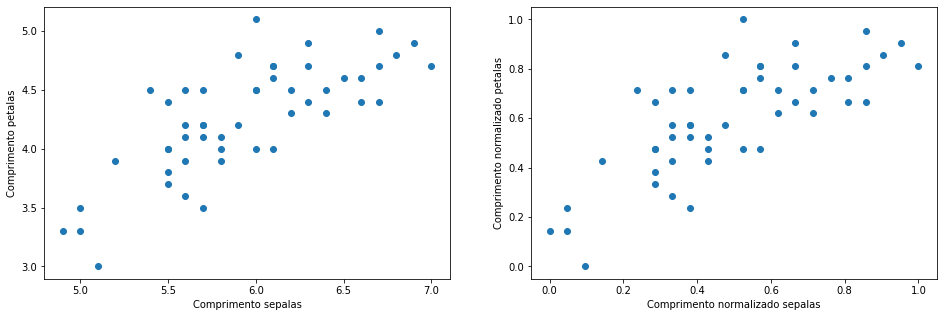

In [87]:
x = x_in - x_in.min()
x /= x.max()    # normalização
y = y_in - y_in.min()
y /= y.max()

fig = plt.figure(figsize=(16,5))
ax_in = fig.add_subplot(1,2,1)
ax_in.scatter(x_in, y_in)
ax_in.set_xlabel('Comprimento sepalas')
ax_in.set_ylabel('Comprimento petalas')
ax_n = fig.add_subplot(1,2,2)
ax_n.scatter(x, y)
ax_n.set_xlabel('Comprimento normalizado sepalas')
ax_n.set_ylabel('Comprimento normalizado petalas');

## Transformando dados em dataset/dataloader


In [15]:
from torch.utils.data import DataLoader, Dataset

### Dataset

In [16]:

class Dados(Dataset):
  def __init__(self, x, y):
    print(f"Dados: len(x) {len(x)} len(y) {len(y)}")
    self.x = torch.from_numpy(np.float32(x))
    self.y = torch.from_numpy(np.float32(y))


  def __len__(self):
    return len(self.x)

  def __getitem__(self, item):
    """
    target = self.targets[item]
    encoding = tokenizer(
      x[0],
      padding=True,
      add_special_tokens=True,
      max_length=250,
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )
    """
    return {
     # 'review_text': review,
      'x': self.x[item] ,
      'y': self.y[item]
    }

#### Testes do dataset

In [17]:
type(y)


numpy.ndarray

In [18]:
x[0:5], y[0:5]

(array([[1.        ],
        [0.71428571],
        [0.95238095],
        [0.28571429],
        [0.76190476]]), array([[0.80952381],
        [0.71428571],
        [0.9047619 ],
        [0.47619048],
        [0.76190476]]))

In [19]:
ds = Dados(x,y)

Dados: len(x) 50 len(y) 50


In [20]:
print(len(ds))

50


In [21]:
ds[0], ds[3]

({'x': tensor([1.]), 'y': tensor([0.8095])},
 {'x': tensor([0.2857]), 'y': tensor([0.4762])})

### Dataloader

In [22]:
dados_loader = DataLoader(ds, batch_size=len(ds), shuffle=True)

#### Testes do dataloader

In [23]:
x_ = next(iter(dados_loader))

print("\nDimensões dos dados de um minibatch X:", x_['x'].size())
print("\nDimensões dos dados de um minibatch Y:", x_['y'].size())


Dimensões dos dados de um minibatch X: torch.Size([50, 1])

Dimensões dos dados de um minibatch Y: torch.Size([50, 1])


# Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/linhareta.png" width="300pt">

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinearNeuronio.png" width="300pt">
$$ \hat{y} = w_0 + w_1 x $$
$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

### Função Custo ou de Perda (MSE - Mean Square Error)

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master//figures/Loss_MSE.png" width = "600pt">


A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .


## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.

O esquema da otimização é representado pelo diagrama a seguir:

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinear_Otimizacao.png" width = "600pt">

e é implementado pela próxima célula de código:

# Implementação

## Funções: Custo, Gradiente Descendente

## Definição do Modelo


In [24]:
class Model(torch.nn.Module): 
  """
  Implements a LinearRegressionModel with torch.nn
  """
  def __init__(self, n_in: int, n_out: int):
    super().__init__()  
    self.linear = torch.nn.Linear(n_in, n_out, bias=True)  # One in and one out
    self.linear.weight
    torch.nn.init.zeros_(self.linear.weight)
    torch.nn.init.zeros_(self.linear.bias)
    print(f"Pesos shape: {self.linear.weight.shape} ")
    print(f"Pesos: {self.linear.weight} ")
    print(f"Bias shape: {self.linear.bias.shape} ")
    print(f"Bias: {self.linear.bias} ")

  def forward(self, x):
    y_pred = self.linear(x)
    return y_pred

### Teste do modelo

In [25]:
xtemp = torch.arange(0,4).float(); xtemp

tensor([0., 1., 2., 3.])

In [26]:
xtemp = xtemp.reshape(-1,1)

In [27]:
xtemp.shape

torch.Size([4, 1])

In [28]:
model_test=Model(1,1)

Pesos shape: torch.Size([1, 1]) 
Pesos: Parameter containing:
tensor([[0.]], requires_grad=True) 
Bias shape: torch.Size([1]) 
Bias: Parameter containing:
tensor([0.], requires_grad=True) 


In [29]:
model_test(xtemp)

tensor([[0.],
        [0.],
        [0.],
        [0.]], grad_fn=<AddmmBackward0>)

In [30]:
model_test.linear.weight.reshape(1,)

tensor([0.], grad_fn=<ReshapeAliasBackward0>)

In [31]:
model_test.linear.bias

Parameter containing:
tensor([0.], requires_grad=True)

### Experimentações de cat e stack

In [33]:
c = 1
c = torch.tensor(c, dtype=torch.int8);c

tensor(1, dtype=torch.int8)

In [34]:
torch.reshape(c, (1,))

tensor([1], dtype=torch.int8)

In [35]:
bbias = model_test.linear.bias; bbias

Parameter containing:
tensor([0.], requires_grad=True)

In [36]:
torch.stack((bbias, torch.reshape(c, (1,))))

tensor([[0.],
        [1.]], grad_fn=<StackBackward0>)

In [37]:
pesos = torch.cat((model_test.linear.bias, model_test.linear.weight.reshape(1,))); pesos

tensor([0., 0.], grad_fn=<CatBackward0>)

In [38]:
pesos.shape

torch.Size([2])

In [39]:
pesos_0 = pesos.reshape(1,2); pesos_0

tensor([[0., 0.]], grad_fn=<ReshapeAliasBackward0>)

In [40]:
pesos_1 = torch.cat((pesos_0, pesos.reshape(1,2))); pesos_1

tensor([[0., 0.],
        [0., 0.]], grad_fn=<CatBackward0>)

In [41]:
pesos_2 = torch.cat((pesos_1, pesos.reshape(1,2))); pesos_2

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<CatBackward0>)

## Métricas

In [42]:
def calcula_loss_tensor(outputs, target, parm_criterion):
  #print(f'entrei calcula_loss outputs type: {type(outputs)} shape: {outputs.shape} target type: {type(target)} shape: {target.shape}')
  if isinstance(parm_criterion, torch.nn.MSELoss):
    print('loss_tensor é instancia de torch.nn.CrossEntropyLoss')
    return parm_criterion(outputs, target)
  elif isinstance(parm_criterion, torch.nn.BCELoss):
    print('loss_tensor é instancia de torch.nn.BCELoss')
    return parm_criterion(outputs, target.reshape(len(target), -1))
  elif isinstance(parm_criterion, torch.nn.BCEWithLogitsLoss):
    print('loss_tensor é instancia de torch.nn.BCEWithLogitsLoss')
    return parm_criterion(outputs, target)    



## Definição do treinamento

### hparam: HiperParametros

In [43]:
def inicia_hparam()->dict:
  # Inicialização dos parâmetros
  hparam = {}
  hparam['max_epochs'] = 21
  hparam["learning_rate"] = 0.5  
  #criterion = torch.nn.CrossEntropyLoss(weight=pesos_classes)
  hparam['criterion'] = torch.nn.BCEWithLogitsLoss() # torch.nn.BCELoss(reduction = 'mean') # torch.nn.CrossEntropyLoss(reduction = 'mean' 
  hparam["device"] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  if torch.cuda.is_available(): print(torch. cuda. get_device_name(dev))    
  return hparam

In [44]:
def validar_hparam(parm_hparam:dict, parm_lista_chaves_esperadas=['max_epochs', 'criterion', 'optimizer', 'device'] ):
  """
  Valida se hparam tem as chaves esperadas em parm_lista_chaves_esperadas
  """
  if sum([key in hparam for key in parm_lista_chaves_esperadas]) != len(parm_lista_chaves_esperadas):
              raise Exception(f'Está faltando parâmetro esperado para treinamento em hparam \
                  {[key for key in parm_lista_chaves_esperadas if key not in hparam]}')

In [45]:
hparam=inicia_hparam()


### Funções

In [46]:
def treina_modelo_com_rastro (parm_model, parm_loader_train, hparam:dict, rastro_neptune, intervalo_print:int = 10):
  """Train a model following hparam directives

  Returns:
      loss_history: a torch.tensor of shape (n_epochs,)
      w_history: a torch.tensor of shape (n_epochs, 2)
      rastro_history (rastro with metrics)
  """
  eps = 10e-6
  rastro_history = []
  print(f'Iniciado treinamento em {time.strftime("%Y-%b-%d %H:%M:%S")}')
  for cnt_epoca in range(1, hparam['max_epochs']+1):
    accumulated_loss = 0
    accumulated_accuracy = 0
    parm_model.train()
    cnt_step = 0
    for idx, batch in enumerate(parm_loader_train):
      # print(f"cnt_epoca {cnt_epoca} idx {idx} len(batch['x']): {len(batch['x'])} ")
      cnt_step += 1
      x = batch["x"].to(hparam['device'])
      y = batch["y"].to(hparam['device'])
      outputs = parm_model(x)
      # print(f"len(x) {len(x)}")
      # print(f"y {y}")
      # print(f"outputs {outputs}")

      # calcula a perda
      #batch_loss = calcula_loss_tensor(outputs + eps, (y + eps).reshape(len(x), -1), hparam['criterion'])
    
      # batch_loss = calcula_loss_tensor(outputs + eps, (y + eps), hparam['criterion'])
      batch_loss = calcula_loss_tensor(outputs, y, hparam['criterion'])

      # batch_loss = calcula_loss_tensor(outputs, y, hparam['criterion'])

      # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
      batch_loss.backward()
      
      # salva no rastro
      metrica_rastro = {"train/loss": batch_loss.item()}  
      rastro_neptune.salva_metrica(metrica_rastro)
      rastro_history.append(metrica_rastro)

      # outros dados a retornar
      pesos = torch.cat((parm_model.linear.bias, parm_model.linear.weight.reshape(1,)))
      if cnt_epoca == 1:
        # print(f"type(batch_loss) {type(batch_loss)}")
        loss_history = torch.reshape(batch_loss, (1,)) 
        w_history = pesos.reshape(1,2)
        # print(f"cnt_epoca {cnt_epoca} loss_history:{loss_history} w_history: {w_history} ")
      else:
        loss_history = torch.cat((loss_history, torch.reshape(batch_loss, (1,)) ))
        w_history = torch.cat((w_history, pesos.reshape(1,2)))

      #print(f'Efetuando cálculo gradiente')
      hparam['optimizer'].step()
      # Reset gradients, for the next accumulated batches
      hparam['optimizer'].zero_grad()

      loss_treino = batch_loss
      if intervalo_print > 0:
        if (cnt_epoca)%intervalo_print == 0: 
          print(f'cnt_epoca {(cnt_epoca):d}/{hparam["max_epochs"]:d} em {time.strftime("%Y-%b-%d %H:%M:%S")} Train Loss: {loss_treino:.6f} ')
          print(f"           loss_history:{loss_history} w_history: {w_history} ")
         
  return loss_history, w_history, rastro_history

### Testando as funções

In [47]:
model = Model(1, 1) # duas entradas (1 + x0) e uma saída y_pred

Pesos shape: torch.Size([1, 1]) 
Pesos: Parameter containing:
tensor([[0.]], requires_grad=True) 
Bias shape: torch.Size([1]) 
Bias: Parameter containing:
tensor([0.], requires_grad=True) 


In [48]:
model.to(hparam['device'])
hparam['optimizer'] = torch.optim.SGD(model.parameters(), lr=hparam['learning_rate']) #torch.optim.Adam(model.parameters(), lr=hparam["learning_rate"])
print(f"hparam: {hparam}")
validar_hparam(hparam, ['max_epochs', 'criterion', 'optimizer', 'device'])


hparam: {'max_epochs': 21, 'learning_rate': 0.5, 'criterion': BCEWithLogitsLoss(), 'device': device(type='cpu'), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    lr: 0.5
    momentum: 0
    nesterov: False
    weight_decay: 0
)}


In [49]:
rastro_neptune = NeptuneRastroRun(hparam, parm_lista_tag=["Mudando função de custo para CrossEntropyLoss"])   

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-10


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
loss_history, w_history, rastro_history = treina_modelo_com_rastro(model, dados_loader, hparam, rastro_neptune, intervalo_print=100)

In [51]:
loss_history = loss_history.detach().numpy()
w_history = w_history.detach().numpy()

In [52]:
loss_history, w_history, rastro_history

(array([0.6931471 , 0.68476546, 0.67864686, 0.67413473, 0.6707633 ,
        0.6682033 , 0.66622144, 0.6646533 , 0.66338164, 0.6623238 ,
        0.66142046, 0.66062975, 0.6599213 , 0.6592736 , 0.65867126,
        0.65810317, 0.6575612 , 0.65703946, 0.6565339 , 0.6560415 ,
        0.65555984], dtype=float32), array([[0.        , 0.        ],
        [0.05000001, 0.04498867],
        [0.0909799 , 0.0851949 ],
        [0.12437999, 0.12136663],
        [0.15141815, 0.15413709],
        [0.1731176 , 0.18403856],
        [0.19033523, 0.2115169 ],
        [0.20378786, 0.23694496],
        [0.21407513, 0.26063457],
        [0.2216991 , 0.28284672],
        [0.22708063, 0.3038001 ],
        [0.23057301, 0.32367828],
        [0.23247327, 0.34263548],
        [0.23303145, 0.36080158],
        [0.23245837, 0.37828606],
        [0.23093195, 0.39518133],
        [0.22860256, 0.4115655 ],
        [0.22559738, 0.42750478],
        [0.22202407, 0.44305512],
        [0.21797384, 0.45826405],
        [0.2

In [53]:
rastro_neptune.gera_grafico_modelo(dados_loader, model)   

In [54]:
rastro_neptune.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 108 operations to synchronize with Neptune. Do not kill this process.


All 108 operations synced, thanks for waiting!


# Função de cálculo do grid de custos

### Montando os valores dos eixos com sobra da diferença nos eixos do gráfico

In [55]:
wmin = w_history.min(axis=0)
wmax = w_history.max(axis=0)
wmin, wmax

(array([0., 0.], dtype=float32),
 array([0.23303145, 0.47317195], dtype=float32))

In [56]:
D =  wmax - wmin; D

array([0.23303145, 0.47317195], dtype=float32)

In [57]:
wmin -= D
wmax += D
wmin, wmax

(array([-0.23303145, -0.47317195], dtype=float32),
 array([0.4660629, 0.9463439], dtype=float32))

In [223]:
w_0_grid = np.linspace(wmin[0], wmax[0], 100)
w_1_grid = np.linspace(wmin[1], wmax[1], 100)

### Calculando a loss no grid de valores dos pesos

In [225]:
w_0_grid.shape

(100,)

In [226]:
def compute_loss_grid(x, y, w_0_grid, w_1_grid):
    """
      Objetivo: retornar o valor da função de custo considerando os valores
        passados dos pesos nos eixos do gráfico: horizontal (w_0_grid) e
        vertical (w_1_grid).

      Para fins ilustrativos, consideremos:
        len(w_0_grid)=len(w_0_grid)=100 (não precisariam ser iguais)
        len(x)=len(y)=50 (precisam ter tamanhos iguais)

      Returns:
        loss_grid: an array with the same shape of w_0_grid x w_1_grid. 
        No caso, de 100 números para cada eixo, será retornado array com 2 dimensões
        com 100 em cada: (100, 100) referentes aos valores da função de custo 
        em cada par, para montar o gráfico.  

      Obs.: antes de implementar, tomei por base solução do colega Edmar Rodrigues
    """
    ww0_torch = torch.from_numpy(np.float32(w_0_grid))
    ww1_torch = torch.from_numpy(np.float32(w_1_grid))
    print(f"ww0_torch.shape: {ww0_torch.shape}")
    print(f"ww1_torch.shape: {ww1_torch.shape}")

    x_torch = torch.from_numpy(np.float32(x))
    y_torch = torch.from_numpy(np.float32(y))
    print(f"x_torch.shape: {x_torch.shape}")
    print(f"y_torch.shape: {y_torch.shape}")


    # Calculo da função e do erro para cada par de pesos
    # Cálculo da função:
    #   Para cada par, somar w0 a w1 * X 
    #   y_hat : array com 50 valores shape: (1, 50)
    # Cálculo do erro (custo):
    #   torch.nn.BCEWithLogitsLoss () sobre y_hat e y_torch
    f_calc =  torch.nn.BCEWithLogitsLoss(reduction='mean')
    loss_grid_erro = np.empty([w_0_grid.shape[0], w_0_grid.shape[0]]) 
    for ndxh, wh in enumerate(ww0_torch):
      if ndxh%10==0:
        print(f"ndxh: {ndxh} wh:{wh}")
      for ndxv, wv in enumerate(ww1_torch):
        # print(f"ndxv: {ndxv} wv:{wv}")
        y_hat = wh + wv * x_torch
        # print(f"y_hat {y_hat}")
        # print(f"y_hat[:,0] {y_hat[:,0]}")
        loss_grid_erro[ndxh, ndxv] = f_calc(y_hat[:,0], y_torch[:,0])
    #print(f"loss_grid_erro {loss_grid_erro}")
    loss_grid_erro = loss_grid_erro.reshape((w_0_grid.shape[0],-1))    
    return loss_grid_erro

In [227]:
loss_grid = compute_loss_grid(x, y, w_0_grid, w_1_grid)

ww0_torch.shape: torch.Size([100])
ww1_torch.shape: torch.Size([100])
x_torch.shape: torch.Size([50, 1])
y_torch.shape: torch.Size([50, 1])
ndxh: 0 wh:-0.23303145170211792
ndxh: 10 wh:-0.16241586208343506
ndxh: 20 wh:-0.0918002724647522
ndxh: 30 wh:-0.021184677258133888
ndxh: 40 wh:0.04943091422319412
ndxh: 50 wh:0.12004650384187698
ndxh: 60 wh:0.19066210091114044
ndxh: 70 wh:0.2612776756286621
ndxh: 80 wh:0.33189326524734497
ndxh: 90 wh:0.4025088846683502


## Funcão de Plot

In [228]:
def show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.3):
    n_samples = y.shape[0]

    # valor ótimo, solução analítica
    # ------------------------------
    x_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((x_bias.T).dot(x_bias)).dot(x_bias.T)).dot(y)    
    x_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    x_all_bias = np.hstack([np.ones((100, 1)), x_all])
    result_opt = x_all_bias.dot(w_opt)    # Predição do valor ótimo
        
    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_grid = fig.add_subplot(1, 3, 1)    # Grid de losses
    ax_loss = fig.add_subplot(1, 3, 2)    # Função perda

    ax_loss.plot(loss_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_grid.pcolormesh(w_0_grid, w_1_grid, loss_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(w_0_grid, w_1_grid, loss_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w')  # Solução analítica.
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    for i, (loss, w) in enumerate(zip(loss_history, w_history)):
        ax_loss.scatter(i, loss)
                            
        ax_grid.scatter(w[0], w[1], c='r', marker='o')
        
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)


## Plotagem iterativa do gradiente descendente, reta ajuste, parâmetros, função perda

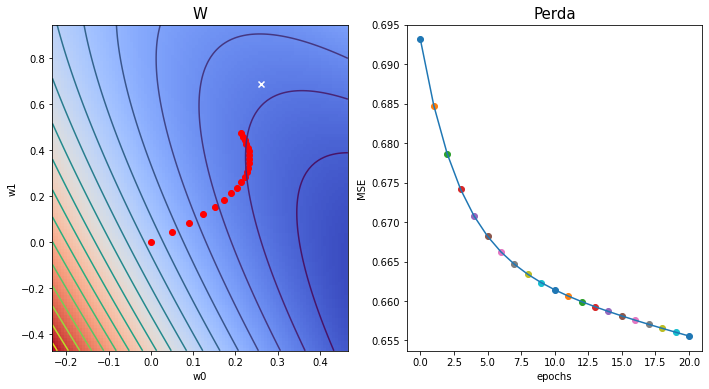

In [229]:
%matplotlib inline
try:
    show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.01)
except KeyboardInterrupt:
    pass